# H.4] Imaginary Time Evolution
d) Numerically integrate random initial state up to certain time $\tau_{\text{max}}$

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from functools import reduce
from scipy.sparse import identity, kron, csr_matrix
from scipy.linalg import expm, eigh

In [219]:
# Set parameters
N = 4
tau_max = 25
Nsteps = 500
dt = tau_max/Nsteps

In [220]:
# Create random initial state
psi0 = np.random.randn(2**N) + 1j*np.random.randn(2**N)

# Normalize
psi0 /= np.linalg.norm(psi0) 
print('Initial state |psi(0)> = ', psi0)

Initial state |psi(0)> =  [ 0.13907334+0.12743709j -0.1881848 +0.11852144j  0.01400408-0.02530923j
  0.45091356-0.13046708j -0.14692132-0.31875215j -0.04911954-0.03260469j
 -0.03494766-0.04264115j  0.14927973-0.01556897j -0.1364577 -0.06227444j
 -0.2061221 +0.09700124j  0.19372156-0.03828997j -0.18965606+0.12113994j
 -0.31204229+0.11805413j -0.30156691+0.33309015j  0.01030034+0.13314593j
  0.21456215-0.02103862j]


In [221]:
# Create Hamiltonian as matrix as done in last sheet:

# Create csr Pauli matrices
id = identity(2, format='csr')
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=np.float64)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=np.float64)

def kronecker(operators):
    # reduce calls the function (first arg) recursively on the list (second arg)
    return reduce(kron, operators)

def build_operator(operator, ind, L):
    # list of L identity operators
    operators = [id] * L

    # replace the ind-th operator with the given operator
    operators[ind] = operator

    # return the kronecker product of all identity matrices and the operator on site ind
    return csr_matrix(kronecker(operators))

def all_operators(operator):
    # a list of L operators, each one acting on a different site, otherwise identity
    return [build_operator(operator, j, N) for j in range(N)]

def Hamiltonian(h=1, J=1):
    # initialize matrices
    H = csr_matrix((2**N, 2**N), dtype=np.complex128)
    sz_list = all_operators(sigma_z)
    sx_list = all_operators(sigma_x)

    for i in range(N-1):
        H += J*(sz_list[i] @ sz_list[i+1]) + h*(sx_list[i])
    return H

In [222]:
# Define derivative using imaginary time SEQ
def dpsi_dtau(tau, psi, h=1, J=1):
    psi = psi.view(dtype=np.complex128)
    return (Hamiltonian(h,J) @ psi).view(dtype=np.float64)

# Numerically integrate this state using real part of initial state |psi(0)>
sol = solve_ivp(dpsi_dtau, t_span = (0, tau_max), y0 = psi0.view(dtype=np.float64), t_eval=np.linspace(0, tau_max, Nsteps))

# Normalize wave functions of each step dt
psi_tau_list = sol.y.T.copy().view(dtype=np.complex128)   # copy to ensure that the memory is laid out cpntiguously before using  changing the data type to complex128
psi_tau_normalized = np.array([psi / np.linalg.norm(psi) for psi in psi_tau_list])

e) Monitor convergence to ground state energy

In [223]:
# Compute energy expectation value
def E(psi, h=1, J=1):
    return np.real(np.vdot(psi, Hamiltonian(h,J) @ psi))

t = 0
E_tau = np.array([])
tau_list = np.linspace(0, tau_max, Nsteps)
for i in range(Nsteps):
    E_tau = np.append(E_tau, E(psi_tau_normalized[i]))

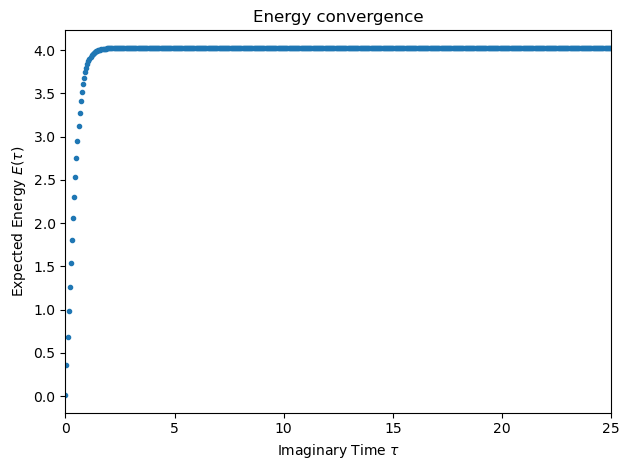

In [224]:
# Plot energy expectation value over time tau
plt.scatter(tau_list,E_tau, marker='.')

plt.xlabel(r'Imaginary Time $\tau$')
plt.ylabel(r'Expected Energy $E(\tau)$')
plt.title('Energy convergence')
plt.xlim(min(tau_list),max(tau_list))

plt.tight_layout()
plt.show()

f) Check if ITP ground state is correct

In [231]:
ITP_groundstate = psi_tau_normalized[-1]
exact_energies, exact_eigenstates = eigh(Hamiltonian().toarray())

overlaps = np.array([])
for i in range(2**N):
    overlaps = np.append(overlaps, np.vdot(ITP_groundstate, exact_eigenstates[:,i]))

print("Overlap of ground states obtained with ITP and exact diagonalization: ", np.abs(overlaps[0]))
print('maximum achieved overlap with any eigenvector:', max(np.abs(overlaps)))
print('(found for energy = ', exact_energies[np.argmax(np.abs(overlaps))],")")
# PROBLEM: ITP Groundstate matches highest state -> sign error in Hamiltonian leading to positive energies instead of negative??
# The absolute maximum was 0.9816 with tau=5. Result depends on initial random overlap

Overlap of ground states obtained with ITP and exact diagonalization:  4.62039342002913e-17
maximum achieved overlap with any eigenvector: 0.9461728943929717
(found for energy =  4.027339492125848 )


g) Compare efficiency of ITP vs real-time adiabatic evolution